In [2]:
from jax import numpy as np
from jax import grad, jit, vmap
import jax.scipy as jsp
import scipy as sp
from jax.lax import conv_general_dilated
import numpy as onp
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random
# import functools

In [4]:
def make_small_multiples(images, name):
    n = int(len(images)**0.5)
    plt.rcParams['figure.facecolor'] = 'black'
    fig, axs = plt.subplots(n, n, figsize=(n * 2, n * 2), dpi=100)
    for i, ax in enumerate(axs.flatten()):
        if name == 'siamese' and i in [4, 10, 16, 22, 28, 34]:
            image = np.zeros_like(images[0])
        else:
            image = images[i]
        # black to red cmap
        ax.imshow(image, cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(f'plots/{name}.png', facecolor='black', dpi=100)
    plt.show()

def make_multiple_smalls(images, name):
    for i in tqdm(range(12)):
        plt.rcParams['figure.facecolor'] = 'black'
        fig, axes = plt.subplots(3, 4, fissile=(9 * 2, 6 * 2), dpi=100)
        sub_images = random.sample(images, 12)
        for j, ax in enumerate(axes.flatten()):
            image = sub_images[j]
            ax.imshow(image, cmap='gray')
            ax.axis('off')
        plt.tight_layout()
        plt.savefig(f'plots/{i}.png', facecolor='black', dpi=100)
        plt.close()
        fig, ax = plt.subplots(1, 1, figsize=(9 * 2, 6 * 2), dpi=100)
        plt.savefig(f'plots/{i}_{random.random()}.png', facecolor='black', dpi=100)


def clip_negative(x):
    if random.random() < 0.2:
        return x.clip(min=0)
    elif random.random() < 0.4:
        x = -x
        x = x.clip(min=0)
        return x
    else:
        return x

In [5]:
def horizontal_derivative(x):
    return x - np.roll(x, 1, axis=1)

def vertical_derivative(x):
    return x - np.roll(x, 1, axis=0)

def diagonal_derivative(x):
    # rotate 45 degrees
    # jax to numpy
    # x = x.detach().numpy()
    if random.random() < 0.5:
        x = sp.ndimage.rotate(x, 45, reshape=False)
    else:
        x = sp.ndimage.rotate(x, -45, reshape=False)
    return x - np.roll(x, 1, axis=0)

def subtract_gasuss(x):
    tmp = np.linspace(-6, 6, 200)
    gaussian = jsp.stats.norm.pdf(tmp, scale=0.5) * jsp.stats.norm.pdf(tmp[:, None], scale=0.5)
    return x + gaussian


def get_derivatives(x):
    return horizontal_derivative(x), vertical_derivative(x), diagonal_derivative(x) # , subtract_gasuss(x)

In [6]:
def morph(x, y, steps=100):
    # given a gausian, x, and its derivative, y, morph one into the other in a biological looking fashion.
    # Create a placeholder for the intermediate figures
    figs = []

    # Normalize the arrays
    x = x / np.max(x)
    y = y / np.max(y)

    # Generate the intermediate steps
    for i in range(steps):
        alpha = i/steps
        # This next line is key: it creates a blend of the two images weighted by the "alpha" variable
        inter = (1.0 - alpha) * x + alpha * y 
        figs.append(inter) 

    return figs

## gaussiann

In [7]:
def get_gaussian():
    x = np.linspace(-6, 6, 800)
    gaussian = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
    return gaussian

def get_gaussian_ring():
    x = np.linspace(-6, 6, 800)
    gaussian = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
    # low variance gaussian
    low_variance_gaussian = jsp.stats.norm.pdf(x, scale=0.6) * jsp.stats.norm.pdf(x[:, None], scale=0.6)
    return low_variance_gaussian - gaussian * 1.5

def get_gaussian_double_ring():
    x = np.linspace(-6, 6, 800)
    gaussian = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
    # low variance gaussian
    low_variance_gaussian = jsp.stats.norm.pdf(x, scale=0.6) * jsp.stats.norm.pdf(x[:, None], scale=0.6)
    return low_variance_gaussian - gaussian * 1.5 + jsp.stats.norm.pdf(x, scale=0.3) * jsp.stats.norm.pdf(x[:, None], scale=0.3) * 0.1

def get_siamese_gaussian():
    off_set = 70
    x = onp.linspace(-8, 8, 800)
    gaussian = sp.stats.norm.pdf(x) * sp.stats.norm.pdf(x[:, None])
    # off set sidewards (columns)
    gaussian[:, off_set:] = gaussian[:, :-off_set]
    gaussian[:, :off_set] = 0
    gaussian2 = sp.stats.norm.pdf(x) * sp.stats.norm.pdf(x[:, None])
    gaussian2[:, :-off_set] = gaussian2[:, off_set:]
    gaussian2[:, -off_set:] = 0
    return gaussian + gaussian2

def get_tripple_siamese_gaussian():
    off_set = 70
    base = get_siamese_gaussian()
    x = onp.linspace(-8, 8, 800)
    gaussian = sp.stats.norm.pdf(x) * sp.stats.norm.pdf(x[:, None])
    # off set base upwards (rows)
    gaussian[2 *off_set:, :] = gaussian[:-2 *off_set, :]
    gaussian[:2 *off_set, :] = 0
    gaussian = gaussian + base
    # off set upwards to center
    gaussian[:-off_set, :] = gaussian[off_set:, :]
    gaussian[-off_set:, :] = 0
    return gaussian


def get_tripple_siamese_gaussian_ring():
    base = get_tripple_siamese_gaussian()
    x = onp.linspace(-8, 8, 800)
    gaussian = sp.stats.norm.pdf(x) * sp.stats.norm.pdf(x[:, None])
    # low variance gaussian
    low_variance_gaussian = sp.stats.norm.pdf(x, scale=0.7) * sp.stats.norm.pdf(x[:, None], scale=0.7)
    return low_variance_gaussian - gaussian - base





# # dark mode 
plt.rcParams['figure.facecolor'] = 'black'
# white title
plt.rcParams['axes.titlecolor'] = 'white'
# font times new roman
plt.rcParams['font.family'] = 'Times New Roman'
# fig, axes = plt.subplots(1, 5, figsize=(9 * 2, 6 * 2), dpi=100)
# names = ['Gaussian', 'Gaussian Ring', 'Siamese Gaussian', 'Tripple Siamese Gaussian', 'Tripple Siamese Gaussian Ring']
# for idx, fn in enumerate([get_gaussian, get_gaussian_ring, get_siamese_gaussian, get_tripple_siamese_gaussian, get_tripple_siamese_gaussian_ring]):
#     ax = axes[idx]
#     ax.imshow(np.abs(fn()), cmap='gray')
#     # ax.set_title(names[idx])
#     ax.axis('off')


In [8]:
# x, y = get_gaussian(), get_gaussian_ring()
# figs = morph(x, y, steps=100)
# make_multiple_smalls(figs, 'morph')


In [9]:
def get_gaussian_derivatives(kernel_fn):
    gaussians = [[kernel_fn()]]
    for _ in range(3):
        derivatives = list(map(get_derivatives, gaussians[-1]))
        derivatives = [item for sublist in derivatives for item in sublist]
        gaussians.append(derivatives)
    return gaussians


def plot_gaussian(name, kernel_fn, kernel_fn2=None, kernel_fn3=None, kernel_fn4=None):
    gaussians = get_gaussian_derivatives(kernel_fn)
    gaussians = [item for sublist in gaussians for item in sublist]
    if kernel_fn2 is not None:
        gaussians2 = get_gaussian_derivatives(kernel_fn2)
        gaussians2 = [item for sublist in gaussians2 for item in sublist]
        gaussians = gaussians + gaussians2m
    if kernel_fn3 is not None:
        gaussians3 = get_gaussian_derivatives(kernel_fn3)
        gaussians3 = [item for sublist in gaussians3 for item in sublist]
        gaussians = gaussians + gaussians3
    if kernel_fn4 is not None:
        gaussians4 = get_gaussian_derivatives(kernel_fn4)
        gaussians4 = [item for sublist in gaussians4 for item in sublist]
        gaussians = gaussians + gaussians4
    # random.shuffle(gaussians)
    gaussians = gaussians[: int(len(gaussians) ** 0.5) ** 2]
    gaussians = list(map(clip_negative, gaussians))
    gaussians = list(map(np.abs, gaussians))
    # make_small_multiples(gaussians, name)
    # make_multiple_smalls(gaussians, name)
    return gaussians

# 2024 

In [10]:
siam, ring, trip = plot_gaussian('siamese', get_siamese_gaussian), plot_gaussian('ring', get_tripple_siamese_gaussian_ring), plot_gaussian('triplet', get_tripple_siamese_gaussian)

In [11]:
imgs = siam + ring + trip
# shuffle images
random.shuffle(imgs)

In [12]:
 def plot_single(ax, img):
    ax.imshow(img, cmap='grey')
    ax.axis('off')
    return ax

In [13]:
def plot_many(imgs, dims, fname, figsize, ignore=None):
    fig, axes = plt.subplots(dims[0], dims[1], figsize=figsize)
    for idx, (ax, img) in enumerate(zip((axes.flatten() if len(imgs) > 1 else [axes]), imgs)):
        img = img if idx not in ignore else np.zeros_like(img)
        plot_single(ax, img)
    plt.tight_layout()
    plt.savefig(fname)

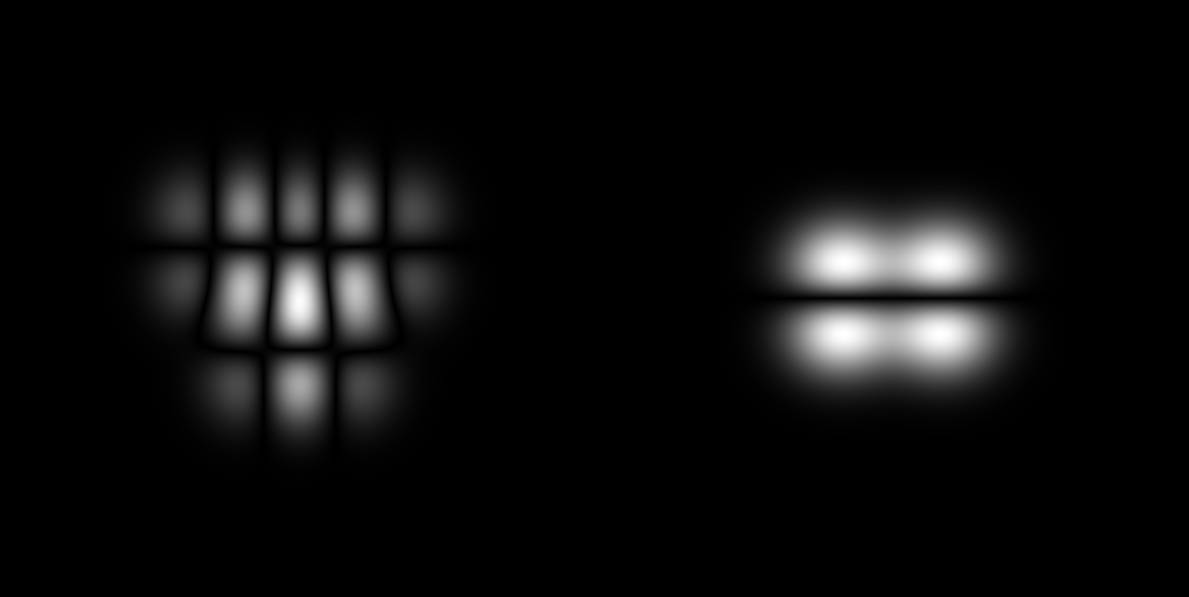

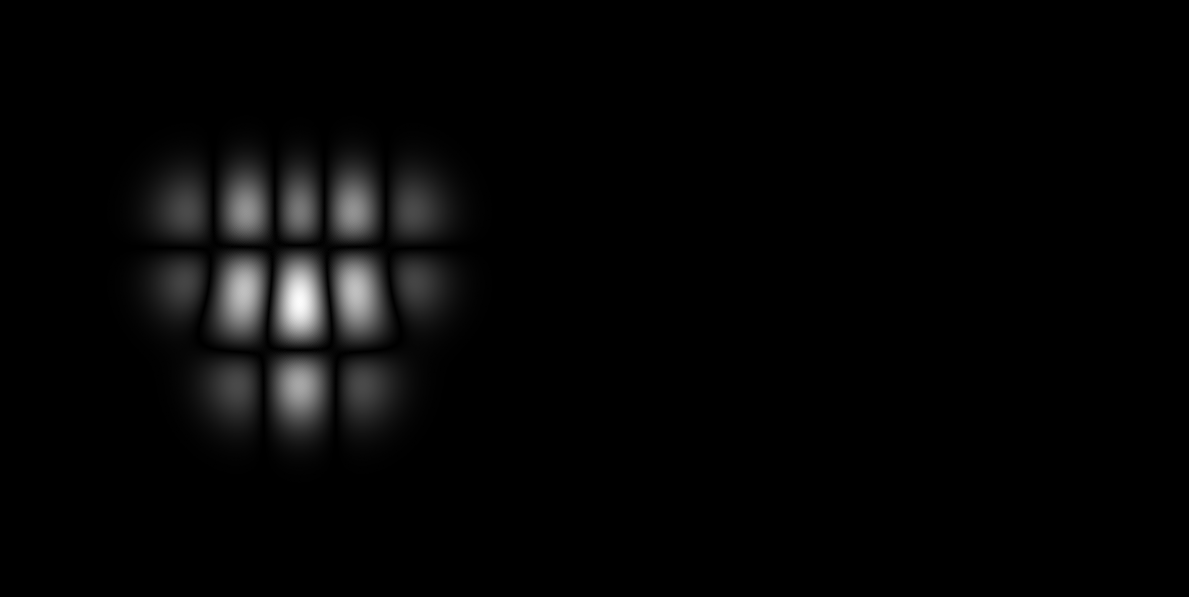

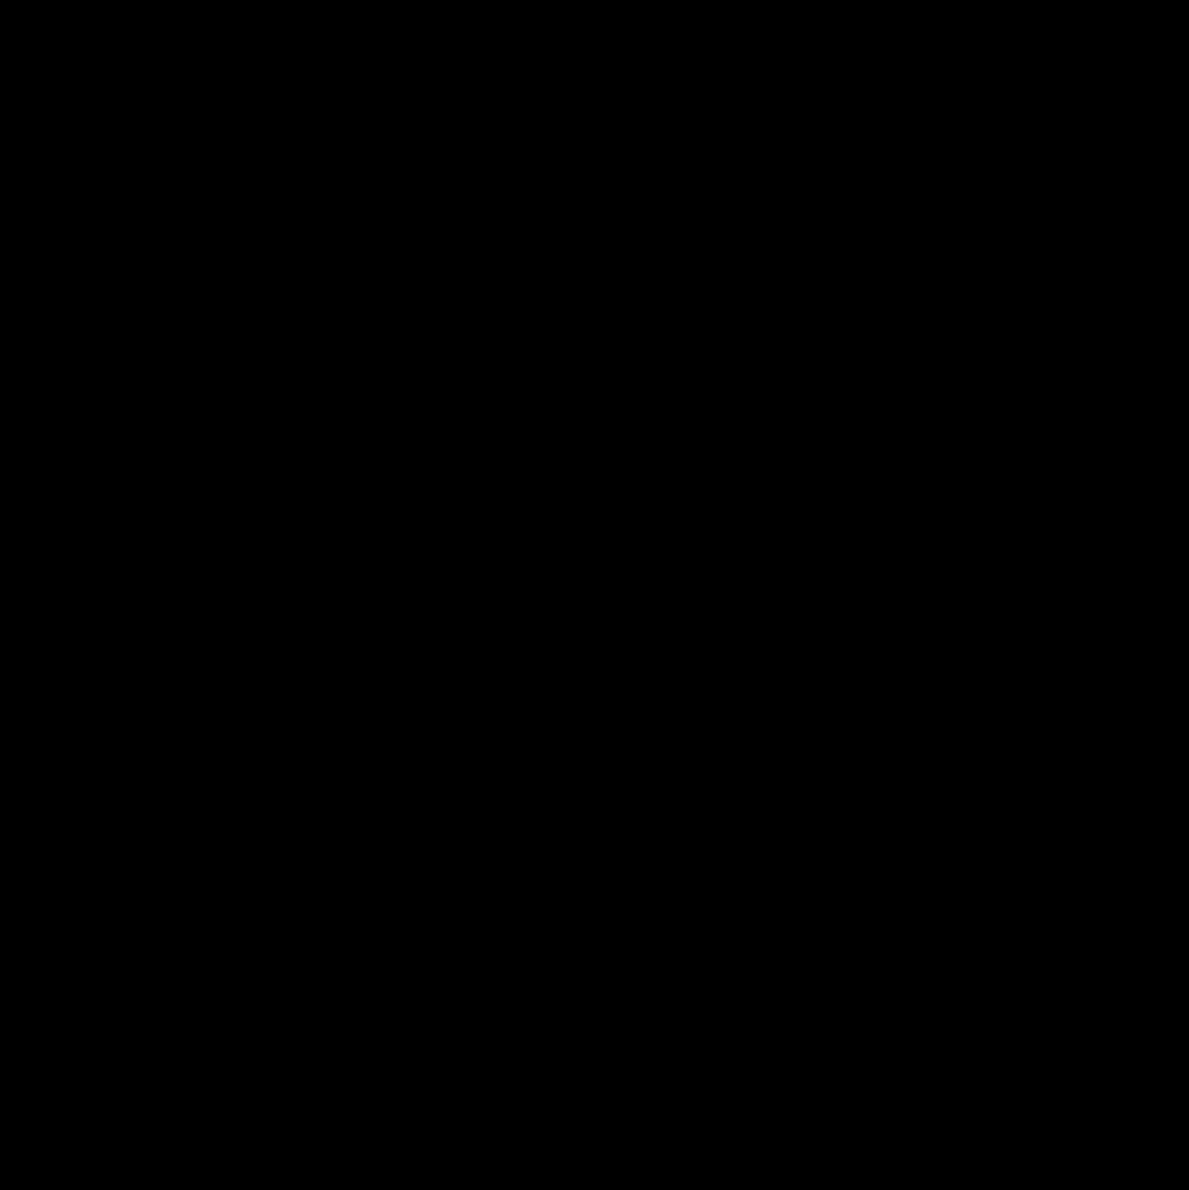

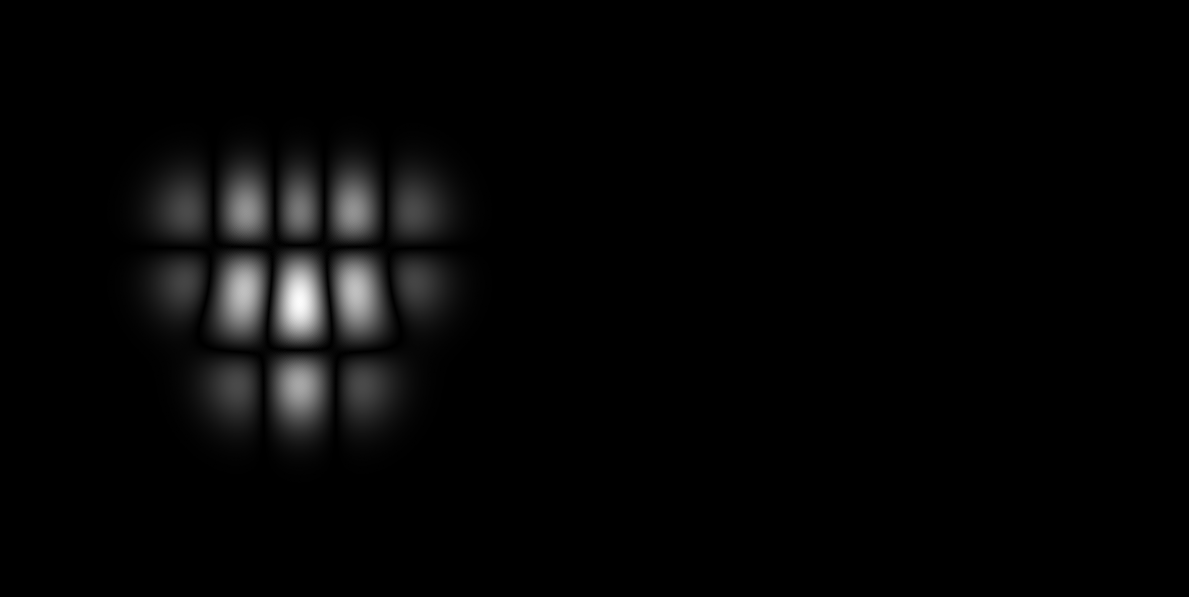

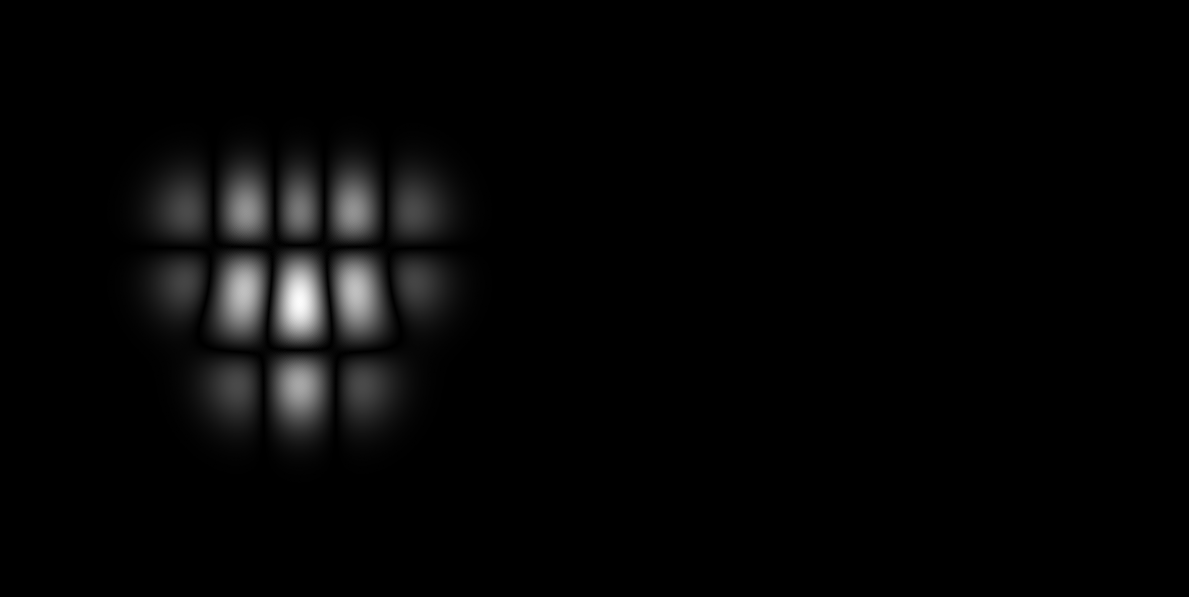

In [23]:
plot_many(imgs, (1, 2), fname='zero.png', figsize=(12, 12), ignore=(11,))
plot_many(imgs, (1, 2), fname='one.png', figsize=(12, 8), ignore=(1, 5))
plot_many([np.zeros_like(ring[0])], (1, 1), fname='two.pdf', figsize=(12, 12), ignore=(1, 5))
plot_many(imgs, (1, 2), fname='three.png', figsize=(12, 8), ignore=(1,))
plot_many(imgs, (1, 2), fname='four.png', figsize=(12, 12), ignore=(1,))
